# Semantic Chunking

We will create a rolling window of sentence embedding and calculate the similary betweent the consequnce windows. Once the similarity is low, we will break the chunks as it means the semantic topic of the windows had changed.

* [Loading a complex dataset of documents](#loading-a-complex-dataset-of-documents)
* [Apply statistical chunker on the document content](#apply-statistical-chunker-on-the-document-content)
* [Add metadata to the chunks](#add-metadata-to-the-chunks)

### Visual improvements

We will use [rich library](https://github.com/Textualize/rich) to make the output more readable, and supress warning messages.

In [1]:
from rich.console import Console
from rich_theme_manager import Theme, ThemeManager
import pathlib

theme_dir = pathlib.Path("themes")
theme_manager = ThemeManager(theme_dir=theme_dir)
dark = theme_manager.get("dark")

# Create a console with the dark theme
console = Console(theme=dark)

In [2]:
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

## Loading a complex dataset of documents

We will load a complex [dataset of scientific documents on AI from Arxiv](https://huggingface.co/datasets/jamescalam/ai-arxiv2). Applying naive chunks on such documents will give poor results in RAG applications.

In [3]:
from datasets import load_dataset

dataset = load_dataset("jamescalam/ai-arxiv2", split="train")
console.print(dataset)

Dataset({
    features: ['id', 'title', 'summary', 'source', 'authors', 'categories', 'comment', 'journal_ref', 
'primary_category', 'published', 'updated', 'content', 'references'],
    num_rows: 2673
})

In [4]:
content = dataset[3]["content"]
console.print(content[:500])

# Mamba: Linear-Time Sequence Modeling with Selective State Spaces
# Albert Gu*1 and Tri Dao*2
1Machine Learning Department, Carnegie Mellon University 2Department of Computer Science, Princeton University 
agu@cs.cmu.edu, tri@tridao.me
# Abstract
Foundation models, now powering most of the exciting applications in deep learning, are almost universally based on
the Transformer architecture and its core attention module. Many subquadratic-time architectures such as linear 
attention, gated convolut

## Apply statistical chunker on the document content

We will use a popular embedding encoder to encode our documents, and use a [statistical chunker](https://github.com/aurelio-labs/semantic-chunkers/tree/main) that will evaluate the semantic similarity (based on the embedding distance) across the sentences to find the best place to split into chunks. 


In [5]:
from dotenv import load_dotenv

load_dotenv()

False

In [6]:
import os
from semantic_router.encoders import OpenAIEncoder

encoder = OpenAIEncoder(name="text-embedding-3-small")

In [7]:
from semantic_chunkers import StatisticalChunker
import logging

logging.disable(logging.CRITICAL)

chunker = StatisticalChunker(
    encoder=encoder,
    min_split_tokens=100,
    max_split_tokens=500,
    plot_chunks=True,
    enable_statistics=True,
)

### Running the statistical chunker on a document

To understand the logic of the statistical chunker we enabled the plots and statistics output.

The chunks of the first document in the dataset:

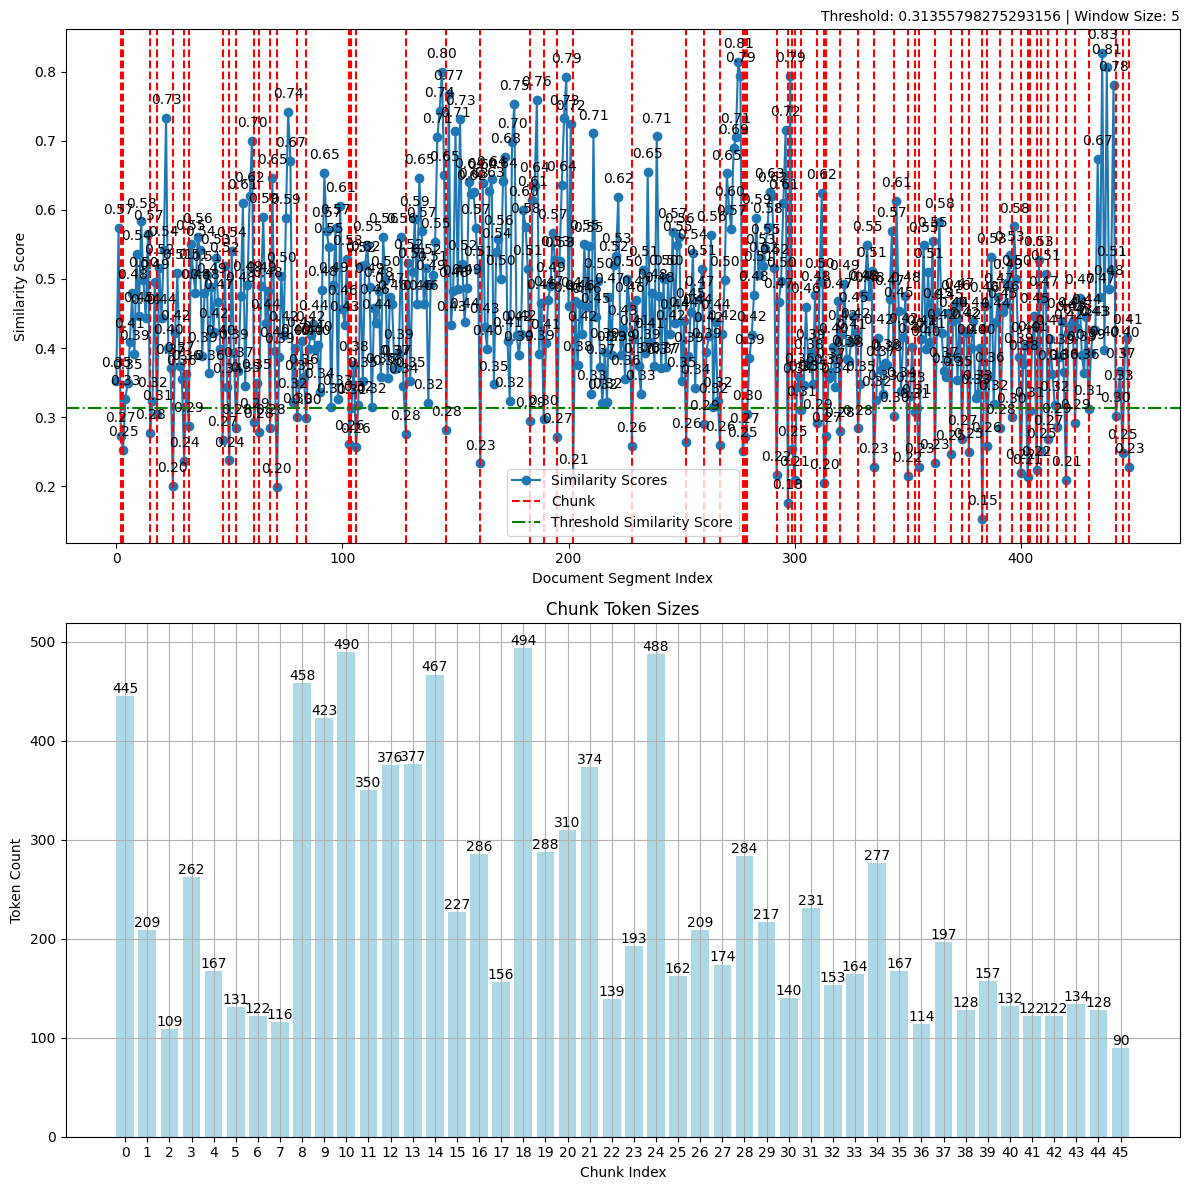

Chunking Statistics:
  - Total Documents: 450
  - Total Chunks: 46
  - Chunks by Threshold: 40
  - Chunks by Max Chunk Size: 5
  - Last Chunk: 1
  - Minimum Token Size of Chunk: 90
  - Maximum Token Size of Chunk: 494
  - Similarity Chunk Ratio: 0.87


In [8]:
chunks_0 = chunker(docs=[dataset["content"][0]])

In [9]:
console.print(chunks_0[0][:5])

[
    Chunk(
        splits=[
            '4 2 0 2',
            'n a J 8 ] G L . s c [',
            '1 v 8 8 0 4 0 . 1 0 4 2 : v i X r a',
            '# Mixtral of Experts',
            'Albert Q.',
            'Jiang, Alexandre Sablayrolles, Antoine Roux, Arthur Mensch, Blanche Savary, Chris Bamford, Devendra 
Singh Chaplot, Diego de las Casas, Emma Bou Hanna, Florian Bressand, Gianna Lengyel, Guillaume Bour, Guillaume 
Lample, LÃ©lio Renard Lavaud, Lucile Saulnier, Marie-Anne Lachaux, Pierre Stock, Sandeep Subramanian, Sophia Yang, 
Szymon Antoniak, Teven Le Scao, ThÃ©ophile Gervet, Thibaut Lavril, Thomas Wang, TimothÃ©e Lacroix, William El 
Sayed',
            'Abstract',
            'We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model.',
            'Mixtral has the same architecture as Mistral 7B, with the difference that each layer is composed of 8 
feedforward blocks (i.e. experts).',
            'For every token, at each layer, a router network selects two experts to process the current state and 
combine their outputs.',
            'Even though each token only sees two experts, the selected experts can be different at each 
timestep.',
            'As a result, each token has access to 47B parameters, but only uses 13B active parameters during 
inference.',
            'Mixtral was trained with a context size of 32k tokens and it outperforms or matches Llama 2 70B and 
GPT-3.5 across all evaluated benchmarks.',
            'In particular, Mixtral vastly outperforms Llama 2 70B on mathematics, code generation, and 
multilingual benchmarks.',
            'We also provide a model fine- tuned to follow instructions, Mixtral 8x7B â',
            'Instruct, that surpasses GPT-3.5 Turbo, Claude-2.1, Gemini Pro, and Llama 2 70B â'
        ],
        is_triggered=True,
        triggered_score=0.2767564165494082,
        token_count=445,
        metadata=None
    ),
    Chunk(
        splits=[
            'chat model on human bench- marks.',
            'Both the base and instruct models are released under the Apache 2.0 license.',
            'Code: https://github.com/mistralai/mistral-src Webpage: https://mistral.ai/news/mixtral-of-experts/',
            '# Introduction',
            'In this paper, we present Mixtral 8x7B, a sparse mixture of experts model (SMoE) with open weights, 
licensed under Apache 2.0.',
            'Mixtral outperforms Llama 2 70B and GPT-3.5 on most benchmarks.',
            'As it only uses a subset of its parameters for every token, Mixtral allows faster inference speed at 
low batch-sizes, and higher throughput at large batch-sizes.',
            'Mixtral is a sparse mixture-of-experts network.',
            'It is a decoder-only model where the feedforward block picks from a set of 8 distinct groups of 
parameters.',
            'At every layer, for every token, a router network chooses two of these groups (the â'
        ],
        is_triggered=True,
        triggered_score=0.2008137999937655,
        token_count=209,
        metadata=None
    ),
    Chunk(
        splits=[
            'expertsâ',
            ') to process the token and combine their output additively.',
            'This technique increases the number of parameters of a model while controlling cost and latency, as 
the model only uses a fraction of the total set of parameters per token.',
            'Mixtral is pretrained with multilingual data using a context size of 32k tokens.',
            'It either matches or exceeds the performance of Llama 2 70B and GPT-3.5, over several benchmarks.',
            'In particular,',
            'Mixture of Experts Layer i gating inputs af outputs router expert'
        ],
        is_triggered=True,
        triggered_score=0.28748985992929027,
        token_count=109,
        metadata=None
    ),
    Chunk(
        splits=[
            'Figure 1:',
            'Mixture of Experts Layer.',
            'Each input vector is assigned to 2 of the 8 experts by a r

Create chunks by default semantic setting and list out each chunks

In [10]:
chunker = StatisticalChunker(encoder=encoder)

In [11]:
content = content[:20_000]
chunks = chunker(docs=[content])
chunker.print(chunks[0])

Split 1, tokens 300, triggered by: token limit
# Mamba: Linear-Time Sequence Modeling with Selective State Spaces # Albert Gu*1 and Tri Dao*2 1Machine Learning Department, Carnegie Mellon University 2Department of Computer Science, Princeton University agu@cs.cmu.edu, tri@tridao.me # Abstract Foundation models, now powering most of the exciting applications in deep learning, are almost universally based on the Transformer architecture and its core attention module. Many subquadratic-time architectures such as linear attention, gated convolution and recurrent models, and structured state space models (SSMs) have been developed to address Transformersâ computational ineï¬ ciency on long sequences, but they have not performed as well as attention on important modalities such as language. We identify that a key weakness of such models is their inability to perform content-based reasoning, and make several improvements. First, simply letting the SSM parameters be functions of the input addr

### Build Chunks for Embedding

Since we cut long documents into pieces, we want to keep the title of the original document as part of the embedding of each chunk as partial context.

In [12]:
from rich.text import Text
from rich.panel import Panel

def build_chunk(title: str, content: str):
    return f"# {title}\n{content}"

title = dataset[0]["title"]
for i, s in enumerate(chunks_0[0][:3]):
    content = Text(build_chunk(title=title, content=s.content))
    console.print(Panel(content, title=f"Chunk {i+1}", expand=False, border_style="bold"))

╭──────────────────────────────────────────────────── Chunk 1 ────────────────────────────────────────────────────╮
│ # Mixtral of Experts                                                                                            │
│ 4 2 0 2 n a J 8 ] G L . s c [ 1 v 8 8 0 4 0 . 1 0 4 2 : v i X r a # Mixtral of Experts Albert Q. Jiang,         │
│ Alexandre Sablayrolles, Antoine Roux, Arthur Mensch, Blanche Savary, Chris Bamford, Devendra Singh Chaplot,     │
│ Diego de las Casas, Emma Bou Hanna, Florian Bressand, Gianna Lengyel, Guillaume Bour, Guillaume Lample, LÃ©lio  │
│ Renard Lavaud, Lucile Saulnier, Marie-Anne Lachaux, Pierre Stock, Sandeep Subramanian, Sophia Yang, Szymon      │
│ Antoniak, Teven Le Scao, ThÃ©ophile Gervet, Thibaut Lavril, Thomas Wang, TimothÃ©e Lacroix, William El Sayed    │
│ Abstract We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model. Mixtral has the same     │
│ architecture as Mistral 7B, with the difference that each layer is composed of 8 feedforward blocks (i.e.       │
│ experts). For every token, at each layer, a router network selects two experts to process the current state and │
│ combine their outputs. Even though each token only sees two experts, the selected experts can be different at   │
│ each timestep. As a result, each token has access to 47B parameters, but only uses 13B active parameters during │
│ inference. Mixtral was trained with a context size of 32k tokens and it outperforms or matches Llama 2 70B and  │
│ GPT-3.5 across all evaluated benchmarks. In particular, Mixtral vastly outperforms Llama 2 70B on mathematics,  │
│ code generation, and multilingual benchmarks. We also provide a model fine- tuned to follow instructions,       │
│ Mixtral 8x7B â Instruct, that surpasses GPT-3.5 Turbo, Claude-2.1, Gemini Pro, and Llama 2 70B â                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 2 ────────────────────────────────────────────────────╮
│ # Mixtral of Experts                                                                                            │
│ chat model on human bench- marks. Both the base and instruct models are released under the Apache 2.0 license.  │
│ Code: https://github.com/mistralai/mistral-src Webpage: https://mistral.ai/news/mixtral-of-experts/ #           │
│ Introduction In this paper, we present Mixtral 8x7B, a sparse mixture of experts model (SMoE) with open         │
│ weights, licensed under Apache 2.0. Mixtral outperforms Llama 2 70B and GPT-3.5 on most benchmarks. As it only  │
│ uses a subset of its parameters for every token, Mixtral allows faster inference speed at low batch-sizes, and  │
│ higher throughput at large batch-sizes. Mixtral is a sparse mixture-of-experts network. It is a decoder-only    │
│ model where the feedforward block picks from a set of 8 distinct groups of parameters. At every layer, for      │
│ every token, a router network chooses two of these groups (the â                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 3 ────────────────────────────────────────────────────╮
│ # Mixtral of Experts                                                                                            │
│ expertsâ ) to process the token and combine their output additively. This technique increases the number of     │
│ parameters of a model while controlling cost and latency, as the model only uses a fraction of the total set of │
│ parameters per token. Mixtral is pretrained with multilingual data using a context size of 32k tokens. It       │
│ either matches or exceeds the performance of Llama 2 70B and GPT-3.5, over several benchmarks. In particular,   │
│ Mixture of Experts Layer i gating inputs af outputs router expert                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

## Add metadata to the chunks

Since our chunks are statistical, we want to be able to retrieve neighboring chunks for the generator as part of the augmentation phase of the RAG. The metadata includes the original document and the adjacent chunks. Neighboring chunks refer to the chunks that come immediately before and after a given chunk in the original document sequence.

In [13]:
arxiv_id = dataset[0]["id"]
refs = list(dataset[0]["references"].values())

metadata = []
for i, chunk in enumerate(chunks_0[0]):
    prechunk = "" if i == 0 else chunks_0[0][i-1].content
    postchunk = "" if i+1 >= len(chunks_0[0]) else chunks_0[0][i+1].content
    metadata.append({
        "title": title,
        "content": chunk.content,
        "prechunk": prechunk,
        "postchunk": postchunk,
        "arxiv_id": arxiv_id,
        "references": refs
    })

In [14]:
def build_metadata(doc: dict, doc_splits):
    # get document level metadata first
    arxiv_id = doc["id"]
    title = doc["title"]
    refs = list(doc["references"].values())
    # init split level metadata list
    metadata = []
    for i, split in enumerate(doc_splits):
        # get neighboring chunks
        prechunk_id = "" if i == 0 else f"{arxiv_id}#{i-1}"
        postchunk_id = "" if i+1 >= len(doc_splits) else f"{arxiv_id}#{i+1}"
        # create dict and append to metadata list
        metadata.append({
            "id": f"{arxiv_id}#{i}",
            "title": title,
            "content": split.content,
            "prechunk_id": prechunk_id,
            "postchunk_id": postchunk_id,
            "arxiv_id": arxiv_id,
            "references": refs
        })
    return metadata

In [15]:
metadata = build_metadata(
    doc=dataset[0],
    doc_splits=chunks_0[0][:3]
)

In [16]:
console.print(metadata)

[
    {
        'id': '2401.04088#0',
        'title': 'Mixtral of Experts',
        'content': '4 2 0 2 n a J 8 ] G L . s c [ 1 v 8 8 0 4 0 . 1 0 4 2 : v i X r a # Mixtral of Experts Albert 
Q. Jiang, Alexandre Sablayrolles, Antoine Roux, Arthur Mensch, Blanche Savary, Chris Bamford, Devendra Singh 
Chaplot, Diego de las Casas, Emma Bou Hanna, Florian Bressand, Gianna Lengyel, Guillaume Bour, Guillaume Lample, 
LÃ©lio Renard Lavaud, Lucile Saulnier, Marie-Anne Lachaux, Pierre Stock, Sandeep Subramanian, Sophia Yang, Szymon 
Antoniak, Teven Le Scao, ThÃ©ophile Gervet, Thibaut Lavril, Thomas Wang, TimothÃ©e Lacroix, William El Sayed 
Abstract We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model. Mixtral has the same 
architecture as Mistral 7B, with the difference that each layer is composed of 8 feedforward blocks (i.e. experts).
For every token, at each layer, a router network selects two experts to process the current state and combine their
outputs. Even though each token only sees two experts, the selected experts can be different at each timestep. As a
result, each token has access to 47B parameters, but only uses 13B active parameters during inference. Mixtral was 
trained with a context size of 32k tokens and it outperforms or matches Llama 2 70B and GPT-3.5 across all 
evaluated benchmarks. In particular, Mixtral vastly outperforms Llama 2 70B on mathematics, code generation, and 
multilingual benchmarks. We also provide a model fine- tuned to follow instructions, Mixtral 8x7B â Instruct, that 
surpasses GPT-3.5 Turbo, Claude-2.1, Gemini Pro, and Llama 2 70B â',
        'prechunk_id': '',
        'postchunk_id': '2401.04088#1',
        'arxiv_id': '2401.04088',
        'references': ['1905.07830']
    },
    {
        'id': '2401.04088#1',
        'title': 'Mixtral of Experts',
        'content': 'chat model on human bench- marks. Both the base and instruct models are released under the 
Apache 2.0 license. Code: https://github.com/mistralai/mistral-src Webpage: 
https://mistral.ai/news/mixtral-of-experts/ # Introduction In this paper, we present Mixtral 8x7B, a sparse mixture
of experts model (SMoE) with open weights, licensed under Apache 2.0. Mixtral outperforms Llama 2 70B and GPT-3.5 
on most benchmarks. As it only uses a subset of its parameters for every token, Mixtral allows faster inference 
speed at low batch-sizes, and higher throughput at large batch-sizes. Mixtral is a sparse mixture-of-experts 
network. It is a decoder-only model where the feedforward block picks from a set of 8 distinct groups of 
parameters. At every layer, for every token, a router network chooses two of these groups (the â',
        'prechunk_id': '2401.04088#0',
        'postchunk_id': '2401.04088#2',
        'arxiv_id': '2401.04088',
        'references': ['1905.07830']
    },
    {
        'id': '2401.04088#2',
        'title': 'Mixtral of Experts',
        'content': 'expertsâ ) to process the token and combine their output additively. This technique increases 
the number of parameters of a model while controlling cost and latency, as the model only uses a fraction of the 
total set of parameters per token. Mixtral is pretrained with multilingual data using a context size of 32k tokens.
It either matches or exceeds the performance of Llama 2 70B and GPT-3.5, over several benchmarks. In particular, 
Mixture of Experts Layer i gating inputs af outputs router expert',
        'prechunk_id': '2401.04088#1',
        'postchunk_id': '',
        'arxiv_id': '2401.04088',
        'references': ['1905.07830']
    }
]